[Colab](https://colab.research.google.com/github/dominik-strutz/Endurance_CCS_design_study/blob/main/endurance_setup.ipynb)

In [1]:

try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False


if IN_COLAB:
    dependencies_installed = False

    if not dependencies_installed:
        ! pip install --quiet zuko
        ! pip install --quiet cartopy
        ! pip install --quiet git+https://github.com/dominik-strutz/GeoBED.git@95f8416397dab58570c4e6c5de8b2e36613c5a57
        ! pip install --quiet ax-platform
        ! pip install --quiet pykonal
        ! pip install --quiet netCDF4

        # ! pip install --quiet obspy
        # clean up working directory
        ! rm -rf *

        ! git clone --quiet https://github.com/dominik-strutz/Endurance_CCS_design_study tmp
        ! mv tmp/* .
        ! rm -rf tmp

        ! mkdir data/eikonal_lookup
        ! gdown -O data/eikonal_lookup/eikonal_lookup_layered_10_rdepth_10_sdepth_500_distance.nc https://drive.google.com/uc?id=1o5V3t5qu4-XiZBPd34SWus-yUI00tx5_
        
        dependencies_installed = True

In [2]:
import os
import torch.distributions as dist
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('https://raw.githubusercontent.com/dominik-strutz/dotfiles/main/mystyle.mplstyle')

from tqdm.notebook import tqdm

import cartopy.crs as ccrs
import xarray as xr

In [3]:
from helpers import *

# Geographic Setting

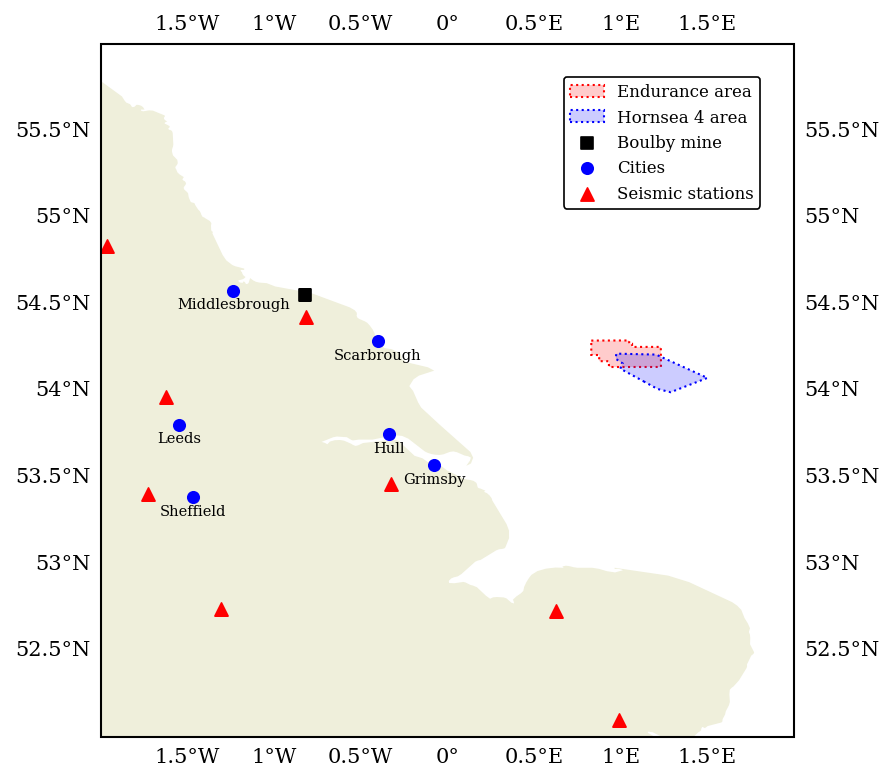

In [4]:
projPC = ccrs.PlateCarree()

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(projection=projPC))

plot_geographic_settings(
    ax, LON_MIN, LON_MAX, LAT_MIN, LAT_MAX,
    landmarks_df, endurance_area_latlon, hornsea_4_latlon,
    seismic_inventory, projPC,
    add_mine=boulby_mine_latlon,
    add_land=True)

plt.show()

# Topography

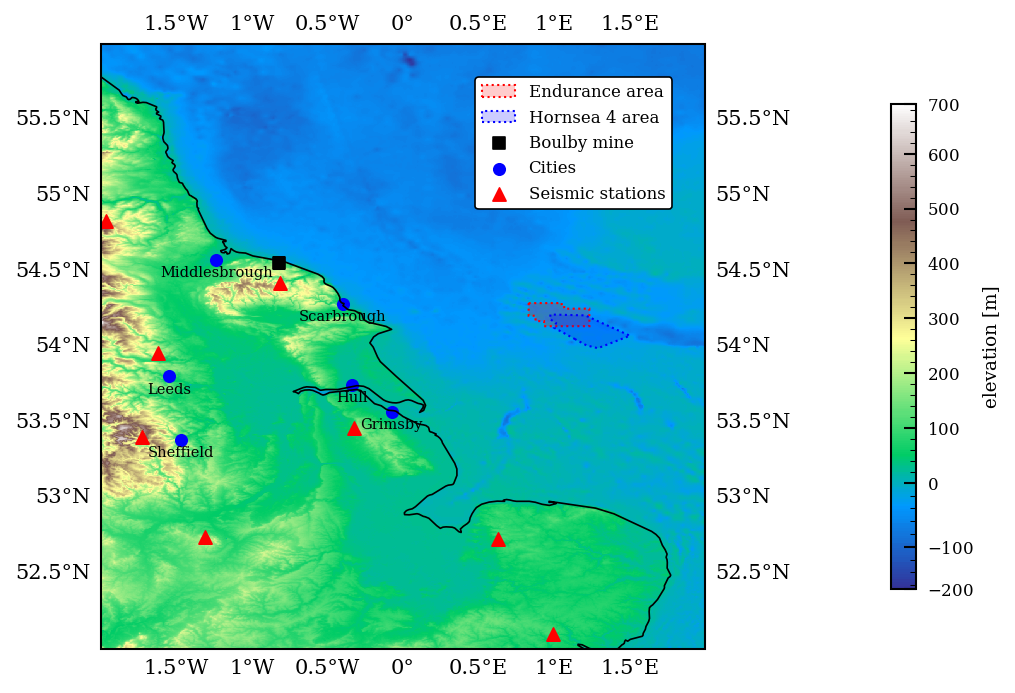

In [5]:
fig, ax = plt.subplots(figsize=(8, 6), subplot_kw=dict(projection=projPC))

plot_geographic_settings(
    ax, LON_MIN, LON_MAX, LAT_MIN, LAT_MAX,
    landmarks_df, endurance_area_latlon, hornsea_4_latlon,
    seismic_inventory, projPC,
    add_mine=boulby_mine_latlon,
    add_coastlines=True)

norm = FixPointNormalize(sealevel=0, vmin=np.nanmin(topo_data_latlon), vmax=np.nanmax(topo_data_latlon))
im = xr.plot.imshow(
    topo_data_latlon, cmap='terrain', x='lon', y='lat', xlim=(LON_MIN, LON_MAX), ylim=(LAT_MIN, LAT_MAX),
    norm=norm, vmin=np.nanmin(topo_data_latlon), vmax=np.nanmax(topo_data_latlon),
    add_colorbar=False)

fig.colorbar(im, label='elevation [m]', shrink=0.7, ax=ax, pad=0.2,)

ax.set_aspect('equal')

plt.show()

# Seismic Model

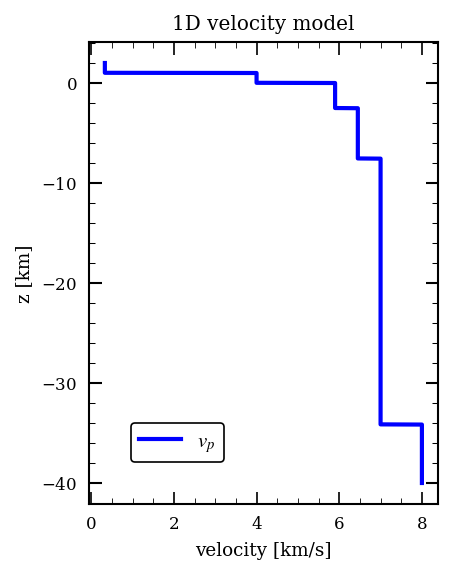

In [6]:
fig, ax = plt.subplots(figsize=(3, 4))

ax.plot(
    seismic_grid[0, :]/1e3,
    seismic_grid.coords['depth']/1e3, 'b', linewidth=2, label=r'$v_p$')

ax.set_xlabel('velocity [km/s]')
ax.set_ylabel('z [km]')

ax.set_title('1D velocity model')

ax.legend(loc='lower left', fontsize=10)

plt.show()

# Inversion Tests

In [7]:
from geobed.core import BED_base_explicit

Forward_Class = TT_Lookup(filename_tt_table)

class Data_Likelihood:
    def __init__(
        self, Forward_Class,
        const_noise_term_multiplier = 1.0,
        quad_noise_term = 0.02
        ):
        
        self.Forward_Class = Forward_Class
        self.const_noise_term_multiplier = const_noise_term_multiplier
        self.quad_noise_term = quad_noise_term
    
    def __call__(self, model_samples, design=None):
    
        model_samples_batch_shape = model_samples.shape[:-1]
        
        model_samples = model_samples.flatten(end_dim=-2)
        data_samples = Forward_Class(model_samples, design)
        data_samples = data_samples.reshape(model_samples_batch_shape + (-1,))
        
        std = (design[:, -1] * self.const_noise_term_multiplier) + \
            (data_samples*self.quad_noise_term)**2

        return dist.Independent(dist.Normal(data_samples, std), 1)

p_d = Data_Likelihood(Forward_Class, 1.0, 0.02)

Test_BED = BED_base_explicit(
    data_likelihood_dist=p_d,
    m_prior_dist=prior_dist,
    )

In [8]:
test_model_samples = (np.array([335.0, 245.0, -1.02]) *1e3)[None, :]

test_xx, test_yy = np.meshgrid(np.linspace(335_000-13_000, 335_000+13_000, 1000), np.linspace(0, 36_000, 1000))

test_design = np.stack([test_xx.ravel(), np.ones_like(test_xx.ravel())*245_000, -test_yy.ravel(), ], axis=1)


test_tt_grid = Forward_Class(test_design, test_model_samples)

test_tt_grid = test_tt_grid.reshape(test_xx.shape)

In [9]:
design_seis_only = seismic_inventory.to_numpy()
design_seis_only[:, :2] = seismic_stations_xy[:, :2]
design_seis_only = torch.from_numpy(design_seis_only).float()
# design_seis_only[:, 2] = -1 * design_seis_only[:, 2]

n_visual_model_samples = int(1e4)

data_likelihoods, _ = Test_BED.get_data_likelihood(
    design_seis_only, n_visual_model_samples)

noisy_data = data_likelihoods.sample()
clean_data = data_likelihoods.mean

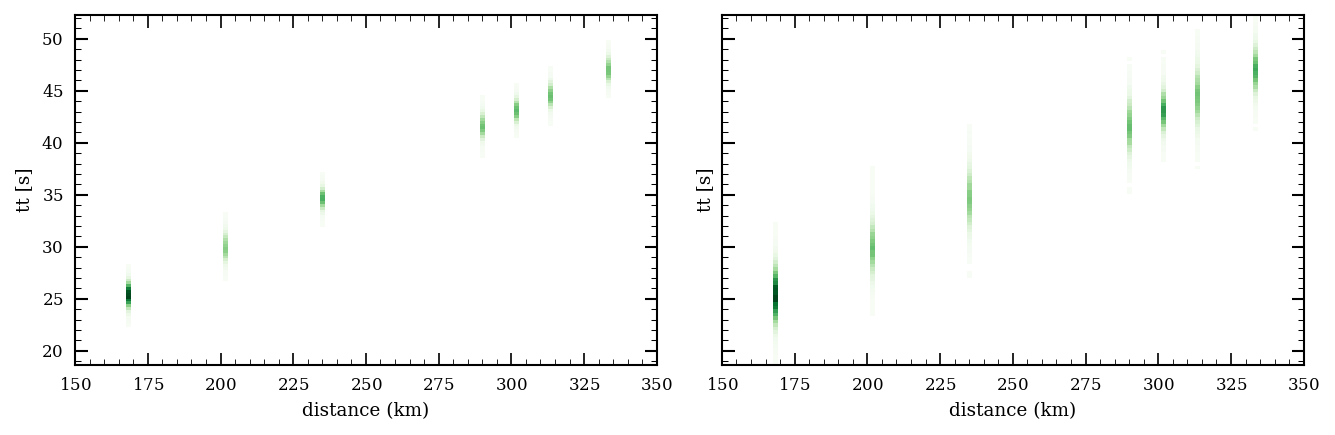

In [10]:
# with style.context('./mpl_stylesheet.mplstyle'):
fig = plt.figure(figsize=(9, 3))
ax_dict = fig.subplot_mosaic(
    '''ab''',
    # gridspec_kw={'wspace': 0.2},
    sharex=True, sharey=True)

ax_dict['a'].hist2d(
    np.sqrt((design_seis_only.squeeze()[:, 1].expand(n_visual_model_samples, -1).flatten().numpy()-wells_coords_xy[0, 1])**2 + \
    (design_seis_only.squeeze()[:, 0].expand(n_visual_model_samples, -1).flatten().numpy()-wells_coords_xy[0, 0])**2)/1e3,
    clean_data.flatten().numpy(),
    bins=[100, 100], cmap='Greens', cmin=1)

ax_dict['b'].hist2d(
    np.sqrt((design_seis_only.squeeze()[:, 1].expand(n_visual_model_samples, -1).flatten().numpy()-wells_coords_xy[0, 1])**2 + \
    (design_seis_only.squeeze()[:, 0].expand(n_visual_model_samples, -1).flatten().numpy()-wells_coords_xy[0, 0])**2)/1e3,
    noisy_data.flatten().numpy(),
    bins=[100, 100], cmap='Greens', cmin=1)
    

for ax in ax_dict.values():
    ax.set_xlim(150, 350)
    ax.set_ylabel('tt [s]')
    ax.set_xlabel('distance (km)')

plt.tight_layout()
plt.show()

In [11]:
true_event = torch.tensor([335.0, 245.0, -1.02]) *1e3

N_grid_posterior = 50

local_x_min, local_x_max = 315_000, 350_000
local_y_min, local_y_max = 235_000, 260_000
local_z_min, local_z_max = -3_000, 0

x_local = torch.linspace(local_x_min, local_x_max, N_grid_posterior)
y_local = torch.linspace(local_y_min, local_y_max, N_grid_posterior)
z_local = torch.linspace(local_z_min, local_z_max, N_grid_posterior)

tt_obs = Forward_Class(true_event[None, :], design_seis_only).squeeze()

p_posterior, p_prior, p_posterior_X, p_posterior_Y, p_posterior_Z = gridsearch_posterior(tt_obs, x_local, y_local, z_local, design_seis_only, prior_dist, p_d)


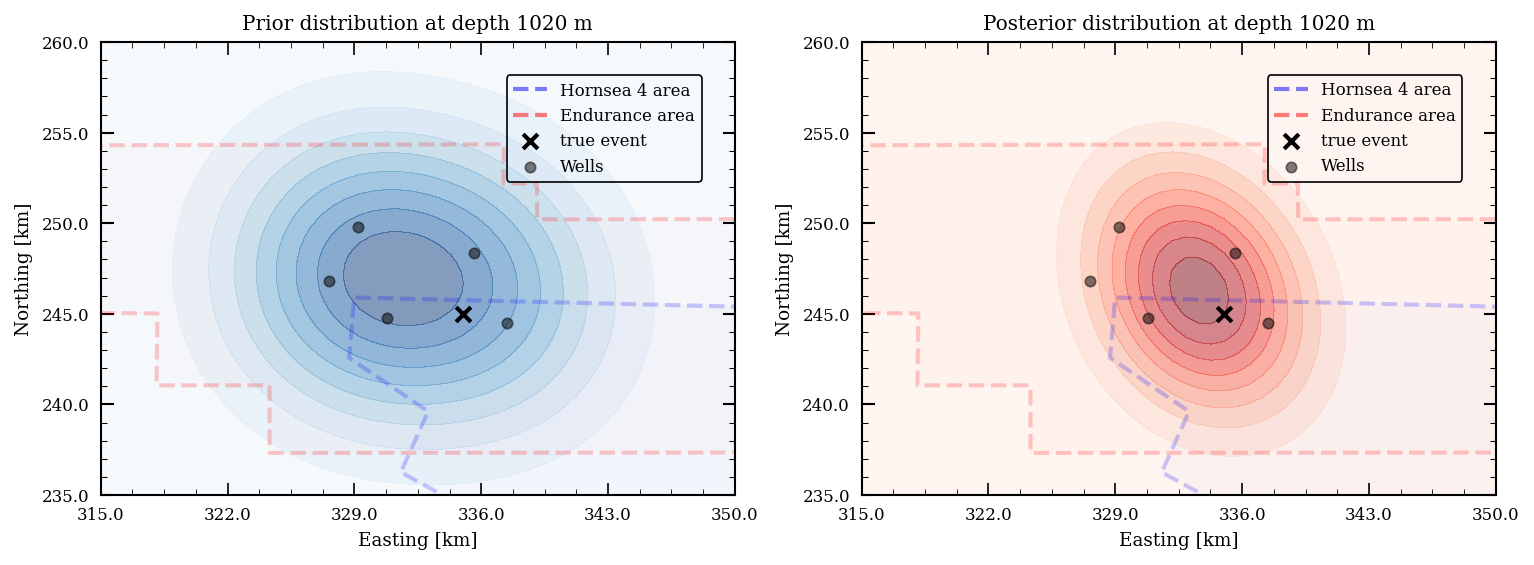

In [12]:
depth = true_event[2]

fig, ax_dict = plt.subplot_mosaic([['a', 'b']], figsize=(12, 6))

ax = ax_dict['a']

plot_modelspace_dist_slice(
    ax, p_prior, p_posterior_X, p_posterior_Y, p_posterior_Z,
    x_local, y_local, z_local,
    slice_axis='z', slice_value=depth,
    contour_kwargs={'levels': 10, 'cmap': 'Blues', 'alpha': 0.5, 'zorder': 0},
    hornsea = hornsea_4_xy,
    endurance = endurance_area_xy,
    wells=wells_coords_xy,
    true_event=true_event,
    )

ax.set_title(f'Prior distribution at depth {-depth:.0f} m')


ax = ax_dict['b']

plot_modelspace_dist_slice(
    ax, p_posterior, p_posterior_X, p_posterior_Y, p_posterior_Z,
    x_local, y_local, z_local, 
    slice_axis='z', slice_value=depth,
    contour_kwargs={'levels': 10, 'cmap': 'Reds', 'alpha': 0.5, 'zorder': 0},
    hornsea = hornsea_4_xy,
    endurance = endurance_area_xy,
    wells=wells_coords_xy,
    true_event=true_event,)

ax.set_title(f'Posterior distribution at depth {-depth:.0f} m')


plt.show()

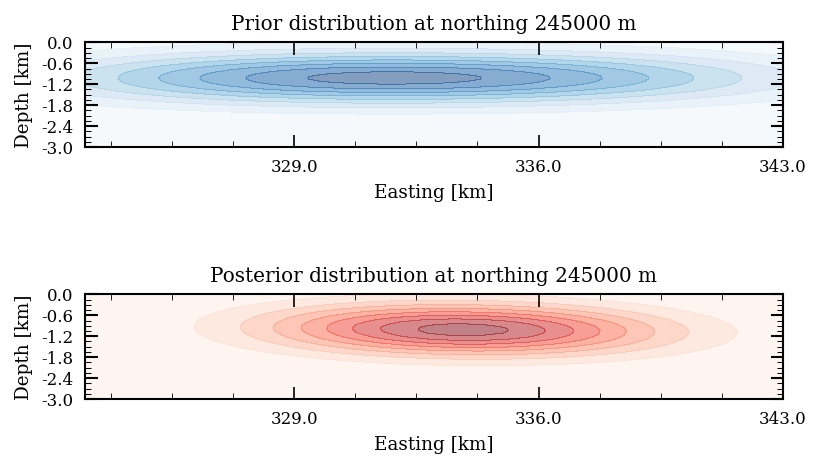

In [13]:
N_slice = true_event[1]

fig, ax_dict = plt.subplot_mosaic([['a'],['b']], figsize=(6, 4))

ax = ax_dict['a']

plot_modelspace_dist_slice(
    ax, p_prior, p_posterior_X, p_posterior_Y, p_posterior_Z,
    x_local, y_local, z_local,
    slice_axis='N', slice_value=N_slice,
    contour_kwargs={'levels': 10, 'cmap': 'Blues', 'alpha': 0.5, 'zorder': 0},)

ax.set_title(f'Prior distribution at northing {N_slice:.0f} m')

ax = ax_dict['b']

plot_modelspace_dist_slice(
    ax, p_posterior, p_posterior_X, p_posterior_Y, p_posterior_Z,
    x_local, y_local, z_local, 
    slice_axis='N', slice_value=N_slice,
    contour_kwargs={'levels': 10, 'cmap': 'Reds', 'alpha': 0.5, 'zorder': 0},)

ax.set_title(f'Posterior distribution at northing {N_slice:.0f} m')


for ax in ax_dict.values():
    ax.set_xlim(323e3, 343e3)

plt.show()